# Ward-Tordai Model Testing Notebook

This notebook is used for testing the Ward-Tordai model implementation and the plotting/fitting functionality.

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Reload the module to pick up changes
import importlib
import sys
if 'ward_tordai_backend' in sys.modules:
    importlib.reload(sys.modules['ward_tordai_backend'])

from ward_tordai_backend import (fit_with_automatic_params, load_experimental_data,
                                   ward_tordai_model_function)

def to_float(series):
    return pd.to_numeric(series.str.replace(',', '.', regex=False), errors='coerce')

In [14]:
def read_data(file_path, delimiter="\t", header=1, skiprows=[2]):
    df = pd.read_csv(file_path, delimiter=delimiter, header=header, skiprows=skiprows)
    # Select the second last and last columns for age and sft
    age = df.iloc[:, -2]
    sft = df.iloc[:, -1]
    age_num_clean = to_float(age)
    sft_num_clean = to_float(sft)
    sorted_idx = np.argsort(age_num_clean)
    age_num_sorted = age_num_clean.iloc[sorted_idx].reset_index(drop=True)
    sft_num_sorted = sft_num_clean.iloc[sorted_idx].reset_index(drop=True)
    return age_num_sorted, sft_num_sorted

In [15]:
from scipy.optimize import curve_fit
from ward_tordai_backend import ward_tordai_model_function

# Load your data
t_data, st_data = read_data(r'C:\Arbeit\Programme\DST\Dynamic-Surface-Tension\Example Data\C12E4_0.1g.txt')

# Convert to numpy arrays
t_data = t_data.values
st_data = st_data.values

# Convert surface tension from mN/m to N/m (SI units)
st_data_SI = st_data / 1000.0

print(f"Data loaded: {len(t_data)} points")
print(f"Time range: {t_data.min():.2f} to {t_data.max():.2f} seconds")
print(f"Surface tension range: {st_data.min():.3f} to {st_data.max():.3f} mN/m")
print(f"Surface tension range (SI): {st_data_SI.min():.6f} to {st_data_SI.max():.6f} N/m")

# Estimate gamma_0 from the first (highest) surface tension value
gamma_0_estimate = st_data_SI[0]
print(f"\nEstimated gamma_0 (pure solvent ST): {gamma_0_estimate:.6f} N/m")

# Define model function with fixed parameters
def model(t, D, gamma_m, kl):
    return ward_tordai_model_function(
        t, D, gamma_m, kl,
        Cb=1e-2,                    # Bulk concentration (mol/m³) - adjust if known
        rb=1.12e-3,                 # Bubble radius (m)
        Tmpr=298.15,                # Temperature (K)
        gamma_0=gamma_0_estimate,   # Solvent surface tension (N/m) - from data
        isotherm=2,                 # Langmuir
        geometry=0                  # Spherical
    )

# Initial guesses: [D, gamma_m, kl]
p0 = [5e-10, 3e-6, 1000]

# Set bounds for physical reasonableness
bounds = (
    [1e-12, 1e-8, 1],          # Lower bounds
    [1e-8, 1e-4, 1e5]          # Upper bounds
)

print("\nFitting... this may take a while...")

# Fit the data
try:
    popt, pcov = curve_fit(
        model, t_data, st_data_SI, 
        p0=p0, 
        bounds=bounds,
        method='trf',
        maxfev=5000
    )
    
    # Calculate standard errors
    perr = np.sqrt(np.diag(pcov))
    
    # Display results
    print("\nFitted Parameters:")
    print(f"D       = {popt[0]:.2e} ± {perr[0]:.2e} m²/s")
    print(f"gamma_m = {popt[1]:.2e} ± {perr[1]:.2e} mol/m²")
    print(f"kl      = {popt[2]:.2e} ± {perr[2]:.2e} m³/mol")
    
    # Calculate R²
    st_fitted = model(t_data, *popt)
    ss_res = np.sum((st_data_SI - st_fitted)**2)
    ss_tot = np.sum((st_data_SI - np.mean(st_data_SI))**2)
    r_squared = 1 - (ss_res / ss_tot)
    print(f"\nR² = {r_squared:.4f}")
    
    # Store for plotting
    fit_success = True
    
except Exception as e:
    print(f"\nFitting failed: {e}")
    import traceback
    traceback.print_exc()
    fit_success = False
    popt = p0
    st_fitted = model(t_data, *p0)
    r_squared = 0

Data loaded: 30 points
Time range: 10.28 to 99726.55 seconds
Surface tension range: 28.624 to 72.702 mN/m
Surface tension range (SI): 0.028624 to 0.072702 N/m

Estimated gamma_0 (pure solvent ST): 0.072702 N/m

Fitting... this may take a while...


KeyboardInterrupt: 

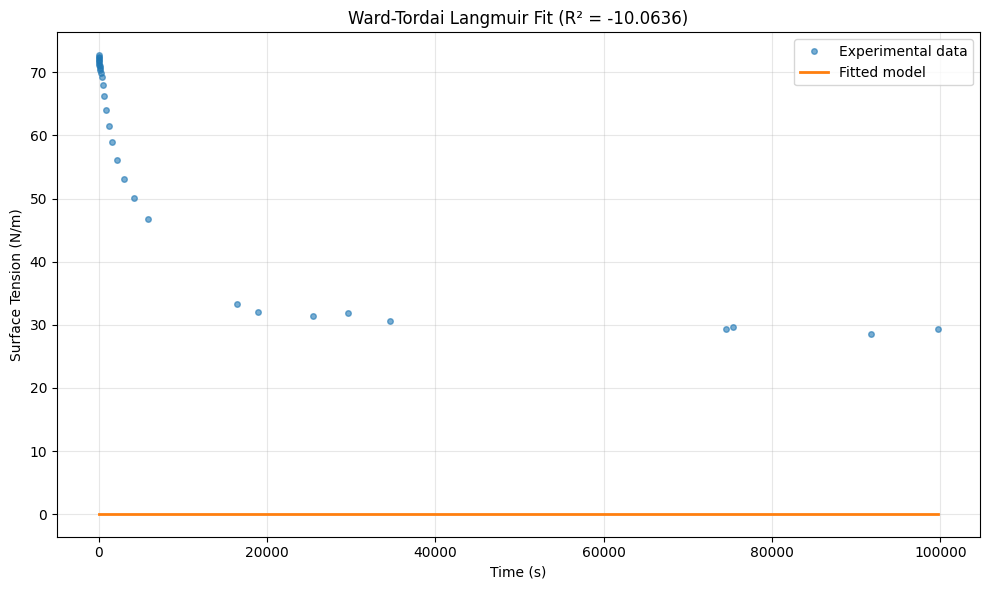

In [ ]:
# Plot the results
if fit_success:
    plt.figure(figsize=(12, 5))
    
    # Plot 1: In mN/m (original units)
    plt.subplot(1, 2, 1)
    plt.plot(t_data, st_data, 'o', label='Experimental data', markersize=5, alpha=0.6)
    plt.plot(t_data, st_fitted * 1000, '-', label='Fitted model', linewidth=2)
    plt.xlabel('Time (s)')
    plt.ylabel('Surface Tension (mN/m)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.title(f'Ward-Tordai Langmuir Fit (R² = {r_squared:.4f})')
    
    # Plot 2: Log scale for time
    plt.subplot(1, 2, 2)
    plt.semilogx(t_data, st_data, 'o', label='Experimental data', markersize=5, alpha=0.6)
    plt.semilogx(t_data, st_fitted * 1000, '-', label='Fitted model', linewidth=2)
    plt.xlabel('Time (s, log scale)')
    plt.ylabel('Surface Tension (mN/m)')
    plt.legend()
    plt.grid(True, alpha=0.3, which='both')
    plt.title('Log-time scale')
    
    plt.tight_layout()
    plt.show()
    
    # Show residuals
    plt.figure(figsize=(10, 4))
    residuals = st_data - st_fitted * 1000
    plt.subplot(1, 2, 1)
    plt.plot(t_data, residuals, 'o-', markersize=4)
    plt.axhline(0, color='r', linestyle='--', alpha=0.5)
    plt.xlabel('Time (s)')
    plt.ylabel('Residuals (mN/m)')
    plt.grid(True, alpha=0.3)
    plt.title('Residuals vs Time')
    
    plt.subplot(1, 2, 2)
    plt.hist(residuals, bins=10, edgecolor='black')
    plt.xlabel('Residuals (mN/m)')
    plt.ylabel('Frequency')
    plt.title('Residual Distribution')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("Fit failed, skipping plots")

In [10]:
# Debug the math domain error more carefully
from ward_tordai_backend import WardTordaiBackend, WardTordaiParams
import traceback

backend = WardTordaiBackend()

# Try with the actual time range from data
test_params = WardTordaiParams(
    D=5e-10,
    gamma_m=3e-6,
    kl=1000,
    Cb=1e-2,
    rb=1.12e-3,
    Tmpr=298.15,
    gamma_0=0.072702,
    isotherm=2,
    geometry=0,
    T=100.0,
    h=0.5
)

print("Testing simulation with actual parameters...")
print(f"  D = {test_params.D}")
print(f"  gamma_m = {test_params.gamma_m}")
print(f"  kl = {test_params.kl}")
print(f"  gamma_0 = {test_params.gamma_0}")

try:
    result = backend.simulate(test_params)
    print(f"\nSimulation SUCCESS!")
    print(f"  Generated {len(result.time)} time points")
    print(f"  Time range: {result.time.min():.2f} to {result.time.max():.2f} s")
    print(f"  Gamma range: {result.gamma.min():.2e} to {result.gamma.max():.2e} mol/m²")
    print(f"  ST range: {result.surface_tension.min():.6f} to {result.surface_tension.max():.6f} N/m")
    print(f"  Converged: {result.converged}")
    
    # Check if gamma exceeds gamma_m (physical impossibility)
    if np.any(result.gamma > test_params.gamma_m):
        print(f"\n  WARNING: gamma exceeds gamma_m at some points!")
        print(f"  Max gamma/gamma_m ratio: {(result.gamma/test_params.gamma_m).max():.4f}")
    
except Exception as e:
    print(f"\nSimulation FAILED: {e}")
    traceback.print_exc()
    
# Now test the model function wrapper
print("\n" + "="*60)
print("Testing ward_tordai_model_function directly...")
test_times = np.array([10.0, 50.0, 100.0])
try:
    st_test = ward_tordai_model_function(
        test_times, 5e-10, 3e-6, 1000,
        Cb=1e-2, rb=1.12e-3, Tmpr=298.15, 
        gamma_0=0.072702, isotherm=2, geometry=0
    )
    print(f"Model function SUCCESS!")
    print(f"  Times: {test_times}")
    print(f"  ST values: {st_test}")
except Exception as e:
    print(f"Model function FAILED: {e}")
    traceback.print_exc()

Testing simulation with actual parameters...
  D = 5e-10
  gamma_m = 3e-06
  kl = 1000
  gamma_0 = 0.072702

Simulation SUCCESS!
  Generated 201 time points
  Time range: 0.00 to 100.00 s
  Gamma range: 0.00e+00 to 2.31e-06 mol/m²
  ST range: 0.061822 to 0.072702 N/m
  Converged: True

Testing ward_tordai_model_function directly...
Model function SUCCESS!
  Times: [ 10.  50. 100.]
  ST values: [0.07224342 0.07052161 0.06887986]
